# Import Modules

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial import ConvexHull
import cv2
from transformers import LlavaNextProcessor, AutoProcessor, LlavaNextForConditionalGeneration, Kosmos2ForConditionalGeneration
import torch
from torchvision.transforms import v2
import tqdm
from PIL import Image
import random

In [2]:
device = torch.device('mps') # For MAC

# 2D Image Generation

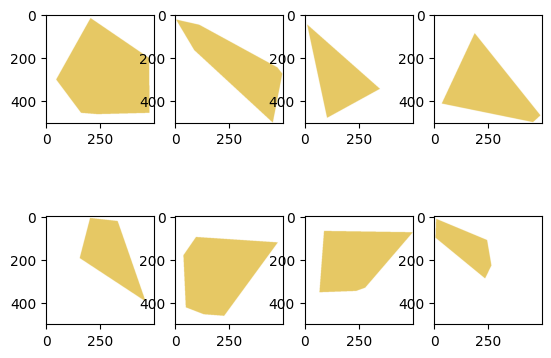

In [3]:
N = 20
size = 500

images = []
for i in range(N):
    points = np.random.rand(7, 2) * size
    hull = ConvexHull(points)
    points = points[hull.vertices]
    points = points.astype(int)

    canvas = np.ones((size, size, 3)) * 255
    canvas = cv2.fillPoly(canvas, [points], (230, 200, 100))
    images.append(canvas)

images = np.array(images)

nrow = 2
ncol = 4

_, axarr = plt.subplots(nrow, ncol)

for i in range(nrow):
    for j in range(ncol):
        axarr[i, j].imshow(images[i * ncol + j].astype(int))

plt.show()

# Perspective Warp

100%|██████████| 20/20 [00:01<00:00, 14.16it/s]


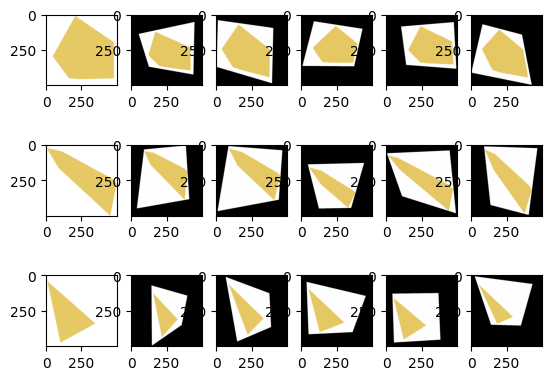

In [4]:
n_perspective = 5

new_images = []

transform = v2.RandomPerspective(distortion_scale=0.6, p=1.)

for i in tqdm.tqdm(range(len(images))):
    warped_images = []
    for j in range(n_perspective):
        warped_image = transform(torch.from_numpy(images[i]).permute(2, 0, 1)).permute(1, 2, 0).numpy()
        warped_images.append(warped_image)
    new_images.append(warped_images)

new_images = np.array(new_images)

nrow = 3
ncol = 5 + 1

_, axarr = plt.subplots(nrow, ncol)

for i in range(nrow):
    axarr[i, 0].imshow(images[i].astype(int))
    for j in range(1, ncol):
        axarr[i, j].imshow(new_images[i, j-1].astype(int))

# Models

### LLaVA

In [4]:
llava_model = LlavaNextForConditionalGeneration.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
llava_processor = LlavaNextProcessor.from_pretrained("llava-hf/llava-v1.6-mistral-7b-hf")
llava_model.generation_config.pad_token_id = llava_model.generation_config.eos_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


### KOSMOS-2

In [6]:
kosmos_processor = AutoProcessor.from_pretrained("microsoft/kosmos-2-patch14-224")
kosmos_model = Kosmos2ForConditionalGeneration.from_pretrained("microsoft/kosmos-2-patch14-224").to(device)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


# Type 1 Error

### Positive Pair Dataset

100%|██████████| 20/20 [00:00<00:00, 37.95it/s]


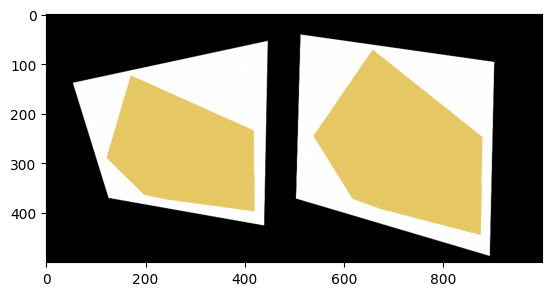

In [8]:
positive_pairs = []

for i in tqdm.tqdm(range(len(images))):
    for j in range(n_perspective):
        for k in range(n_perspective):
            if j == k:
                continue
            positive_pairs.append(np.concat((new_images[i, j], new_images[i, k]), axis=1))

positive_pairs = np.array(positive_pairs)

plt.imshow(positive_pairs[0].astype(int))
plt.show()

### Test on LLaVA

In [8]:
prompt = '''
[INST] <image>\n
USER:
There are two 2D yellow shapes. Both are originally at the 2D plane, but viewed at the different 3D perspective. 
Two shapes may or may not be same (congruent) in the original 2D plane. Are they same?
Answer in yes or no (only in a single word, without period)
[/INST]
'''

error = 0

with torch.no_grad():
    # for i in tqdm.tqdm(range(len(positive_pairs))):
    for i in tqdm.tqdm(range(10)):
        image = positive_pairs[i].astype(np.uint8)
        image = Image.fromarray(image)

        inputs = llava_processor(text=prompt, images=image, return_tensors='pt')

        generated_ids = llava_model.generate(**inputs, max_new_tokens=64)
        generated_text = llava_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        ans = generated_text.split()[-1]

        if ans.lower() != 'yes':
            error += 1

llava_type1_error = error / 10
print(llava_type1_error)

100%|██████████| 10/10 [1:02:52<00:00, 377.21s/it]

0.0


### Test on KOSMOS-2

In [10]:
prompt = '''
USER:
There are two 2D yellow shapes. Both are originally at the 2D plane, but viewed at the different 3D perspective. 
Two shapes may or may not be same (congruent) in the original 2D plane. Are they same?
Answer in yes or no (only in a single word, without period)

ASSISTANT:
'''

error = 0

for i in tqdm.tqdm(range(len(positive_pairs))):
    image = positive_pairs[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = kosmos_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = kosmos_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = kosmos_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = kosmos_processor.post_process_generation(generated_text, cleanup_and_extract=False)

    ans = processed_text.split()[-1]

    if ans.lower() != 'yes':
        error += 1

kosmos_type1_error = error / len(positive_pairs)

100%|██████████| 400/400 [03:18<00:00,  2.02it/s]


In [15]:
print(kosmos_type1_error)

0.0


# Type 2 Error

### Negative Pair Dataset

100%|██████████| 20/20 [00:00<00:00, 24.17it/s]


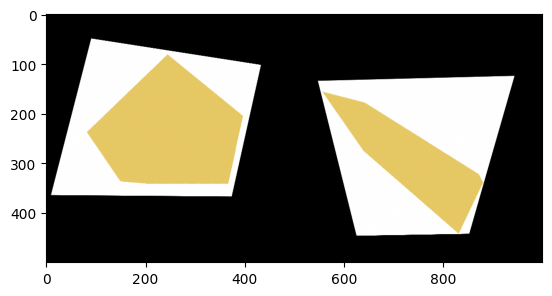

In [11]:
negative_pairs = []

for i in tqdm.tqdm(range(len(images))):
    for j in range(len(images)):
        if i == j:
            continue
        n1 = np.random.randint(0, n_perspective)
        n2 = np.random.randint(0, n_perspective)
        negative_pairs.append(np.concat((new_images[i, n1], new_images[j, n2]), axis=1))

negative_pairs = np.array(negative_pairs)

plt.imshow(negative_pairs[0].astype(int))
plt.show()

### Test on LLaVA

In [6]:
prompt = '''
[INST] <image>\n
USER:
There are two 2D yellow shapes. Both are originally at the 2D plane, but viewed at the different 3D perspective. 
Two shapes may or may not be same (congruent) in the original 2D plane. Are they same?
Answer in yes or no (only in a single word, without period)
[/INST]
'''

error = 0

with torch.no_grad():
    # for i in tqdm.tqdm(range(len(positive_pairs))):
    for i in tqdm.tqdm(range(10)):
        image = negative_pairs[i].astype(np.uint8)
        image = Image.fromarray(image)

        inputs = llava_processor(text=prompt, images=image, return_tensors='pt')

        generated_ids = llava_model.generate(**inputs, max_new_tokens=64)
        generated_text = llava_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        ans = generated_text.split()[-1]

        if ans.lower() != 'no':
            error += 1

llava_type1_error = error / 10
print(llava_type1_error)

100%|██████████| 10/10 [1:00:25<00:00, 362.60s/it]

0.4


### Test on KOSMOS-2

In [12]:
prompt = '''
USER:
There are two 2D yellow shapes. Both are originally at the 2D plane, but viewed at the different 3D perspective. 
Two shapes may or may not be same (congruent) in the original 2D plane. Are they same?
Answer in yes or no (only in a single word, without period)

ASSISTANT:
'''

error = 0

for i in tqdm.tqdm(range(len(negative_pairs))):
    image = negative_pairs[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = kosmos_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = kosmos_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = kosmos_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = kosmos_processor.post_process_generation(generated_text, cleanup_and_extract=False)

    ans = processed_text.split()[-1]

    if ans.lower() != 'no':
        error += 1

kosmos_type2_error = error / len(negative_pairs)

100%|██████████| 380/380 [04:06<00:00,  1.54it/s]


<function print(*args, sep=' ', end='\n', file=None, flush=False)>

In [16]:
print(kosmos_type2_error)

1.0


# Multiple Choice

### Question Dataset

100%|██████████| 20/20 [00:00<00:00, 49.85it/s]


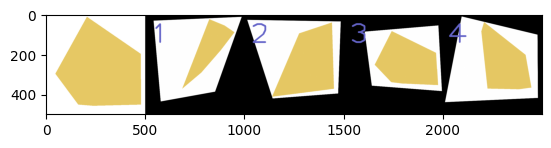

answer: 3


In [13]:
questions = []
answers = []

for i in tqdm.tqdm(range(len(images))):
    original = images[i]
    composite = original.copy()
    
    indices = set(range(len(images)))
    indices.discard(i)
    indices = random.sample(list(indices), k=3)
    indices.append(i)
    random.shuffle(indices)

    for num, j in enumerate(indices):
        k = np.random.randint(0, len(new_images[j]))
        im = cv2.putText(new_images[j, k].copy(), str(num+1), (25, 150), cv2.FONT_HERSHEY_PLAIN, 10, (100, 100, 200), 7, cv2.LINE_AA)
        composite = np.concat((composite, im), axis=1)

    questions.append(composite)
    answers.append(indices.index(i) + 1)

questions = np.array(questions)
plt.imshow(questions[0].astype(int))
plt.show()
print(f'answer: {answers[0]}')

### Test on LLaVA

In [9]:
prompt = '''
[INST] <image>\n
There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective.
One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape?
You should answer only in number from 1 to 4 (in a single word, without period).
[/INST]
'''

correct = 0

for i in tqdm.tqdm(range(10)):
    image = questions[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = llava_processor(text=prompt, images=image, return_tensors='pt')

    generated_ids = llava_model.generate(**inputs, max_new_tokens=64)
    generated_text = llava_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

    ans = generated_text.split()[-1]
    print(ans)

    if ans == str(answers[i]):
        correct += 1

print(correct / 10)

 10%|█         | 1/10 [06:07<55:07, 367.54s/it]

1


 20%|██        | 2/10 [11:59<47:44, 358.11s/it]

1


 30%|███       | 3/10 [17:53<41:33, 356.24s/it]

1


 40%|████      | 4/10 [23:49<35:37, 356.20s/it]

1


 50%|█████     | 5/10 [29:41<29:34, 354.91s/it]

1


 60%|██████    | 6/10 [35:32<23:33, 353.36s/it]

1


 70%|███████   | 7/10 [41:32<17:47, 355.77s/it]

1


 80%|████████  | 8/10 [47:23<11:48, 354.12s/it]

1


 90%|█████████ | 9/10 [1:13:12<12:07, 727.73s/it]

1


100%|██████████| 10/10 [1:19:12<00:00, 475.24s/it]

1
0.2


### Test on KOSMOS-2

In [20]:
prompt = '''
USER:
There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective.
One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape?
You should answer only in number from 1 to 4 (in a single word, without period).

ASSISTANT:
'''

correct = 0

for i in tqdm.tqdm(range(len(questions))):
    image = questions[i].astype(np.uint8)
    image = Image.fromarray(image)

    inputs = kosmos_processor(text=prompt, images=image, return_tensors='pt').to(device)

    generated_ids = kosmos_model.generate(
        pixel_values=inputs["pixel_values"],
        input_ids=inputs["input_ids"],
        attention_mask=inputs["attention_mask"],
        image_embeds=None,
        image_embeds_position_mask=inputs["image_embeds_position_mask"],
        use_cache=True,
        max_new_tokens=64,
    )
    generated_text = kosmos_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    processed_text = kosmos_processor.post_process_generation(generated_text, cleanup_and_extract=False)

    ans = processed_text.split()[-1]
    print(processed_text)

    if ans == answers[i]:
        correct += 1

print(correct / len(questions))

  5%|▌         | 1/20 [00:01<00:36,  1.93s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 10%|█         | 2/20 [00:04<00:41,  2.30s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the image with the conjugate object to a 2D object is the same as the image looking at a 3D object.


 15%|█▌        | 3/20 [00:06<00:34,  2.05s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 20%|██        | 4/20 [00:08<00:31,  1.95s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 25%|██▌       | 5/20 [00:09<00:28,  1.90s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 30%|███       | 6/20 [00:11<00:26,  1.86s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 35%|███▌      | 7/20 [00:13<00:23,  1.84s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 40%|████      | 8/20 [00:15<00:21,  1.83s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 45%|████▌     | 9/20 [00:17<00:20,  1.82s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 50%|█████     | 10/20 [00:19<00:20,  2.01s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the image with the conjugate object to a 2D object is the same to both the left and right images.


 55%|█████▌    | 11/20 [00:21<00:17,  1.94s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 60%|██████    | 12/20 [00:23<00:15,  1.89s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 65%|██████▌   | 13/20 [00:24<00:13,  1.86s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 70%|███████   | 14/20 [00:26<00:11,  1.83s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 75%|███████▌  | 15/20 [00:28<00:09,  1.82s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 80%|████████  | 16/20 [00:30<00:08,  2.02s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the image with the conjugate object to a 2D object is the same to both the left and rightmost shapes.


 85%|████████▌ | 17/20 [00:32<00:05,  1.95s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 90%|█████████ | 18/20 [00:34<00:03,  1.91s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


 95%|█████████▌| 19/20 [00:36<00:01,  1.90s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.


100%|██████████| 20/20 [00:38<00:00,  1.91s/it]

 USER: There is a yellow shape in the original 2D plane on the left. The four images with numbers (from 1 to 4) are the images looking at some 2D plane in some 3D perspective. One of them has the congruent(same) object to the original 2D shape. Among 1 to 4, which is same to the leftmost shape? You should answer only in number from 1 to 4 (in a single word, without period). ASSISTANT: Yes, the yellow shape is the same to both the original and the 3D planes.
0.0
